# 2020-01-27

Trying to use the spaCy package as a means to do the embedding and classification of comments based on topics

In [1]:
import pickle
import pandas as pd
import random
import numpy as np
import pandas as pd
import re

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_lg

from tqdm.notebook import tqdm
from pprint import pprint

C:\ProgramData\Anaconda3\envs\insight\lib\site-packages\thinc\neural\train.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from .optimizers import Adam, SGD, linear_decay
C:\ProgramData\Anaconda3\envs\insight\lib\site-packages\thinc\check.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import defaultdict, Sequence, Sized, Iterable, Callable
C:\ProgramData\Anaconda3\envs\insight\lib\site-packages\thinc\check.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import defaultdict, Sequence, Sized, Iterable, Callable


In [2]:
insight_dir = 'C:\\Users\\Ronald Maj\\Documents\\GitHub\\InsightDataProject\\'

# Load vids data
vids_df = pd.read_csv(insight_dir+'data\\processed\\all_vids_en_df.csv', index_col=0)

# Load comments data
comms_df = pd.read_csv(insight_dir+'data\\processed\\all_comments_en_df.csv', index_col=0)

C:\ProgramData\Anaconda3\envs\insight\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
nlp= spacy.load("en_core_web_lg")

#spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
stop_list = ["say","get"]

# Updates spaCy's default stop words list with my additional words. 
nlp.Defaults.stop_words.update(stop_list)

# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True

In [4]:
comms_df['textDisplay'][10450]

'Kylie you forgot to disable the comment section'

In [5]:
eg = comms_df['textDisplay'][10450]

In [6]:
eg_doc = nlp(eg)

In [7]:
eg_doc

Kylie you forgot to disable the comment section

In [8]:
def lemmatizer(doc):
    # This takes in a doc of tokens from the NER and lemmatizes them. 
    # Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
    
def remove_stopwords(doc):
    # This will remove stopwords and punctuation.
    # Use token.text to return strings, which we'll need for Gensim.
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True and len(token) >= 3]
    return doc

# The add_pipe function appends our functions to the default pipeline.
nlp.add_pipe(lemmatizer,name='lemmatizer',after='ner')
nlp.add_pipe(remove_stopwords, name="stopwords", last=True)

In [9]:
comms_df = comms_df.dropna(subset=['textDisplay'])

In [10]:
comm_docs = comms_df['textDisplay']

In [11]:
# Cleaning
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

comm_docs = [deEmojify(doc) for doc in comm_docs]

In [12]:
def clean_text(text):
    # lower case:
    text = text.lower()
    # replace new line and return with space
    text = text.replace("\n", " ").replace("\r"," ")
    # replace punctuation marks with space
    punc_list = '!"#$%&()*+,-./:;<=>?@[\]{}|^_~' + '0123456789'
    t=str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.translate(t)
    # replace single quote with empty character
    t = str.maketrans(dict.fromkeys("'`",""))
    text = text.translate(t)
    return text

# Remove new line characters
comm_docs = [re.sub('\s+', ' ', sent) for sent in comm_docs]

# Remove Emails/handles
comm_docs = [re.sub('\S*@\S*\s?', '', doc) for doc in comm_docs]
# Clean
comm_docs = [clean_text(comm) for comm in comm_docs]

<>:7: DeprecationWarning: invalid escape sequence \]
<>:16: DeprecationWarning: invalid escape sequence \s
<>:19: DeprecationWarning: invalid escape sequence \S
<>:7: DeprecationWarning: invalid escape sequence \]
<>:16: DeprecationWarning: invalid escape sequence \s
<>:19: DeprecationWarning: invalid escape sequence \S
<>:7: DeprecationWarning: invalid escape sequence \]
<>:16: DeprecationWarning: invalid escape sequence \s
<>:19: DeprecationWarning: invalid escape sequence \S
<ipython-input-12-12015504f488>:7: DeprecationWarning: invalid escape sequence \]
  punc_list = '!"#$%&()*+,-./:;<=>?@[\]{}|^_~' + '0123456789'
<ipython-input-12-12015504f488>:16: DeprecationWarning: invalid escape sequence \s
  comm_docs = [re.sub('\s+', ' ', sent) for sent in comm_docs]
<ipython-input-12-12015504f488>:19: DeprecationWarning: invalid escape sequence \S
  comm_docs = [re.sub('\S*@\S*\s?', '', doc) for doc in comm_docs]


In [13]:
random.sample(comm_docs,10)

['please collab with bernadette banner  i wanna see victorian era safiya  ',
 'why does this guy look like he had multiple failed plastic surgeries ',
 'good vibes always on this channel    anyways im about to bad santa it up at a local pub in santa gear for karaoke coz lifes too short to worry when everyone else around you is too lazy to go on  get out there',
 'hey girl hey  ',
 'nobody  literally  alex as gaga  i won a award yes i won a grammy',
 'actually aristotle dropped maria callas for jackie when she became available  he was never serious about lee radziwell  jackies sister  jackie was a prize many powerful men went after  sadly  callas became a recluse for the rest of her life ',
 ' family is closer than you think    are    are you my sister  ',
 'i refuse to believe hes any older than      ',
 '    s  darling i love you        and i oop sksksks omg i like lowkey like you highkey lowkey thats the tea',
 'imma need that brown dress and cardigan they are so dang cute ']

In [14]:
nlp.pipeline

[('tagger', <spacy.pipeline.Tagger at 0x29ca0897188>),
 ('parser', <spacy.pipeline.DependencyParser at 0x29ca3102468>),
 ('ner', <spacy.pipeline.EntityRecognizer at 0x29ca3102a08>),
 ('lemmatizer', <function __main__.lemmatizer(doc)>),
 ('stopwords', <function __main__.remove_stopwords(doc)>)]

In [15]:
comm_docs_samp = random.sample(comm_docs,10000)

In [16]:
comm_docs_samp[0:5]

[' it looks more like a brain then i thought it would   what the hell ',
 'hello  and welcome back to joel destroys jonas within the first    seconds of the video  on todays episode  we will be calling him boring ',
 ' where you at  billy blanks    i loved taebo too   ',
 '      okay grab a dog  ',
 'julien has the least toxic masculinity ive ever seen']

In [17]:
doc_list = []
# Iterates through each article in the corpus.
for doc in tqdm(comm_docs_samp):
    # Passes that article through the pipeline and adds to a new list.
    pr = nlp(doc)
    doc_list.append(pr)

In [18]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(doc_list, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[doc_list], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

doc_list = make_bigrams(doc_list)
doc_list = make_trigrams(doc_list)

In [19]:
random.sample(doc_list,4)

[['wolf', 'like', 'green', 'know', 'favourite'],
 ['love', 'bby', '   ', 'happy', 'new', 'year', 'bbyy'],
 ['excited', 'follow', 'journey', 'inspire', 'write'],
 ['       ', 'good', 'old']]

In [20]:
wh_sp = ' '

list_of_space = [wh_sp*i for i in range(1,21)]

In [22]:
def wh_sp_rm(x):
    return x in list_of_space

In [23]:
for idx,doc in enumerate(doc_list):
    doc_list[idx] = [x for x in doc if not wh_sp_rm(x)]

In [27]:
# Creates, which is a mapping of word IDs to words.
words = corpora.Dictionary(doc_list)

# Turns each document into a bag of words.
corpus = [words.doc2bow(doc) for doc in doc_list]

In [28]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           num_topics=10, 
                                           random_state=2,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [29]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, words)
vis

C:\ProgramData\Anaconda3\envs\insight\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.120210 -0.055648       1        1  15.413772
2      0.040542 -0.186748       2        1  12.100415
4      0.061167 -0.099548       3        1  11.363021
3     -0.106947  0.060629       4        1  10.440310
5     -0.128796 -0.061666       5        1  10.281646
6     -0.081936  0.217386       6        1   9.295513
8     -0.064607 -0.015501       7        1   8.610855
7      0.167263  0.090534       8        1   8.323017
9      0.024343  0.018377       9        1   7.785273
0      0.209182  0.032184      10        1   6.386177, topic_info=    Category         Freq    Term        Total  loglift  logprob
17   Default  1247.000000    love  1247.000000  30.0000  30.0000
517  Default   235.000000     omg   235.000000  29.0000  29.0000
2    Default  1083.000000    like  1083.000000  28.0000  28.0000
51   Default   319.000000   thank   319.000000  27.0000  27.0000
660  Default   300.000000     lol   300.000000  26.0000  26.0000
..       ...          ...     ...          ...      ...      ...
105  Topic10    37.352970     guy   199.338806   1.0764  -4.7100
13   Topic10    49.988552   video   711.214233   0.0959  -4.4186
54   Topic10    45.835022    good   575.044922   0.2216  -4.5053
274  Topic10    19.973648   voice    50.121372   1.8310  -5.3360
385  Topic10    18.630713  notice    38.812393   2.0171  -5.4056

[623 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1226      1  0.038831  absolutely
1226      4  0.232988  absolutely
1226      6  0.563054  absolutely
1226      8  0.155325  absolutely
1448      3  0.906393      accent
...     ...       ...         ...
419       7  0.156036     youtube
419       9  0.339608     youtube
444       9  0.357958    youtuber
444      10  0.639211    youtuber
261       2  0.987292         zoe

[1041 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 5, 4, 6, 7, 9, 8, 10, 1])

In [30]:
## Find the number of topics that maximises coherence, minimises perplexity

def topics_and_coherence(corpus,data_texts,word_dict,max_topics):
    num_topics = [i for i in range(1,max_topics+1)]
    coh_scores = []
    for num in num_topics:
        
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=word_dict,
                                           num_topics=num, 
                                           random_state=2,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        
        coherence_model_lda = CoherenceModel(model=lda_model, texts=data_texts, dictionary=word_dict, coherence='c_v')
        coh_scores.append(coherence_model_lda.get_coherence())
        
    return num_topics,coh_scores


num_topics,coh_scores = topics_and_coherence(corpus,doc_list,words,20)

In [31]:
import matplotlib.pyplot as plt

In [32]:
num_topics

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [33]:
maxpos = coh_scores.index(max(coh_scores))  

In [34]:
maxpos

18

In [35]:
coh_scores[maxpos]

0.4318218145629274

In [36]:
max(coh_scores)

0.4318218145629274

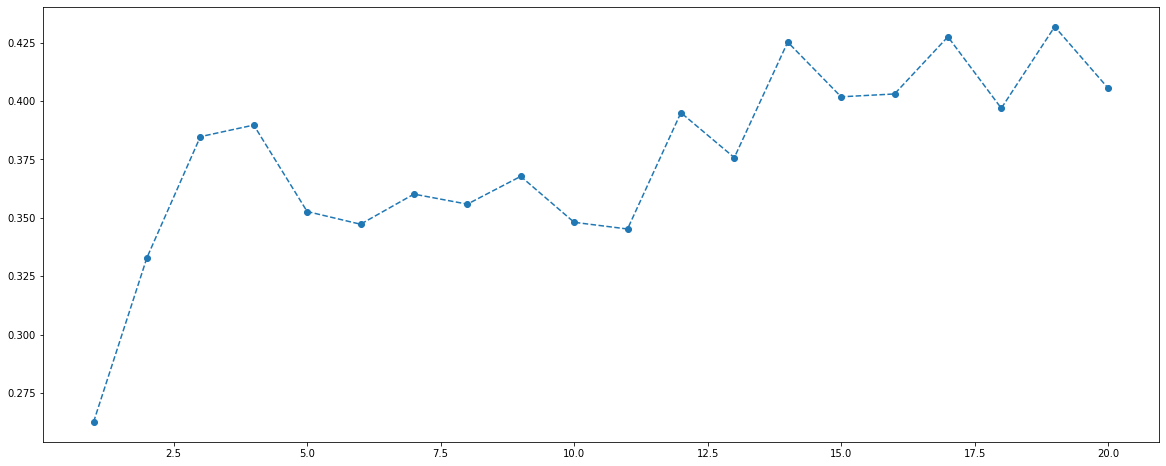

In [41]:
plt.figure(figsize=(20,8))
plt.plot(num_topics,coh_scores,'o--')

#### Based on the above, we can see that number of topics seems to peak at 3 and 4 for the early number of topics, and 19 further down.

Maybe we can try 3, 6, 15 and 18 and see how we go:

In [38]:
lda_model_3_topics = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           num_topics=3, 
                                           random_state=2,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

lda_model_4_topics = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           num_topics=4, 
                                           random_state=2,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

lda_model_14_topics = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           num_topics=14, 
                                           random_state=2,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

lda_model_18_topics = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           num_topics=19, 
                                           random_state=2,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [39]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_3_topics, corpus, words)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.209409  0.094154       1        1  59.198769
2     -0.005785 -0.196568       2        1  27.751614
0     -0.203625  0.102413       3        1  13.049624, topic_info=     Category         Freq     Term        Total  loglift  logprob
2     Default  1031.000000     like  1031.000000  30.0000  30.0000
17    Default  1322.000000     love  1322.000000  29.0000  29.0000
13    Default   741.000000    video   741.000000  28.0000  28.0000
54    Default   597.000000     good   597.000000  27.0000  27.0000
83    Default   388.000000    watch   388.000000  26.0000  26.0000
...       ...          ...      ...          ...      ...      ...
706    Topic3    13.025146     hold    17.216217   1.7574  -6.4781
589    Topic3    14.591781  totally    39.876778   1.0311  -6.3645
560    Topic3    13.936493  support    38.868752   1.0107  -6.4105
477    Topic3    15.151714      use   177.652023  -0.4253  -6.3269
1098   Topic3    12.723584     city    20.714830   1.5490  -6.5015

[179 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
234       2  0.988012  adorable
3448      3  0.972854      alex
897       3  0.933615     alive
61        1  0.999465   amazing
2909      3  0.906562     apple
...     ...       ...       ...
149       2  0.003848      year
84        1  0.963442       yes
84        2  0.026039       yes
84        3  0.006510       yes
419       1  0.998536   youtube

[220 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [40]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_4_topics, corpus, words)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.203239 -0.070411       1        1  49.425186
3      0.023013 -0.057855       2        1  20.141872
2     -0.005792  0.204591       3        1  16.411671
0     -0.220460 -0.076325       4        1  14.021264, topic_info=    Category         Freq   Term        Total  loglift  logprob
17   Default  1350.000000   love  1350.000000  30.0000  30.0000
13   Default   761.000000  video   761.000000  29.0000  29.0000
2    Default  1045.000000   like  1045.000000  28.0000  28.0000
83   Default   398.000000  watch   398.000000  27.0000  27.0000
54   Default   606.000000   good   606.000000  26.0000  26.0000
..       ...          ...    ...          ...      ...      ...
306   Topic4    20.952343  leave    75.519310   0.6825  -6.0746
477   Topic4    23.108574    use   180.922729  -0.0933  -5.9766
111   Topic4    24.335602   want   279.556335  -0.4767  -5.9249
99    Topic4    23.201912    new   190.217285  -0.1393  -5.9726
888   Topic4    19.004923   stay    43.599709   1.1342  -6.1721

[262 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1994      2  0.983742       act
234       2  0.025259  adorable
234       3  0.959858  adorable
1909      1  0.177768     agree
1909      2  0.276528     agree
...     ...       ...       ...
84        2  0.329752       yes
84        3  0.074944       yes
84        4  0.517111       yes
419       1  0.997339   youtube
261       2  0.977587       zoe

[380 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_14_topics, corpus, words)
vis

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_18_topics, corpus, words)
vis

Try the above calculation on a larger sample of comments

In [ ]:
comm_docs_samp2 = random.sample(comm_docs,20000)

In [ ]:
doc_list2 = []
# Iterates through each article in the corpus.
for doc in tqdm(comm_docs_samp2):
    # Passes that article through the pipeline and adds to a new list.
    pr = nlp(doc)
    doc_list2.append(pr)

Topic analysis using the spaCy pipeline to process the data seems a little better in that the topics are more spread out, but it is still difficult to interpret.

I am going to try just having the spaCy output (word2vec) and use terms to see which are most related

In [ ]:
comms_df = comms_df.dropna(subset=['textDisplay'])

In [ ]:
comm_docs = comms_df['textDisplay']

In [ ]:
comm_docs[0:5]

In [ ]:
floats_list =[]
for doc in comm_docs:
    if type(doc) == type(1.2):
        floats_list.append(doc)

In [ ]:
floats_list

In [ ]:
# Cleaning emojis
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

comm_docs = [deEmojify(doc) for doc in comm_docs]

In [ ]:
def clean_text_spa(text):
    # lower case:
    text = text.lower()
    # replace new line and return with space
    text = text.replace("\n", " ").replace("\r"," ")
    # replace punctuation marks with space
    #punc_list = '!"#$%&()*+,-./:;<=>?@[\]{}|^_~' + '0123456789'
    #t=str.maketrans(dict.fromkeys(punc_list, " "))
    #text = text.translate(t)
    # replace single quote with empty character
    #t = str.maketrans(dict.fromkeys("'`",""))
    #text = text.translate(t)
    return text

comm_docs = [clean_text_spa(doc) for doc in comm_docs]

In [ ]:
comm_docs[20:35]

## Load language model from spaCy - nlp()

In [ ]:
nlp2 = spacy.load("en_core_web_lg")

## Choose a sample of 50,000 comments:

In [ ]:
docs_samp = random.sample(comm_docs,50000)

## Run the nlp pipeline on the comments

In [ ]:
spa_docs= []
for doc in tqdm(docs_samp):
    # Passes that article through the pipeline and adds to a new list.
    pr = nlp2(doc)
    spa_docs.append(pr)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

## Assign a keyword/s of interest

In [ ]:
eg_doc = nlp2('canon')

In [ ]:
# Create a matrix of the search term/s doc:
eg_vec = eg_doc.vector.reshape(1,-1)

In [ ]:
eg_vec.shape

## Matrix database

In [ ]:
# Create a matrix of the database:

# Empty matrix
comms_vec = np.zeros((len(spa_docs),300))

# Go through each doc and save the word2vec vector to the matrix:
for idx,doc in enumerate(spa_docs):
    comms_vec[idx] = doc.vector.reshape(1,-1)

In [ ]:
comms_vec.shape

In [ ]:
np.transpose(comms_vec).shape

## Cosine similarity between keyword/s with the database of comments:

In [ ]:
sim_mat = cosine_similarity(eg_vec,comms_vec)

## Set a threshold of similarity for comments with keyword/s

In [ ]:
tf_ar = sim_mat > 0.42

In [ ]:
result = [x for idx,x in enumerate(spa_docs) if tf_ar[0][idx]]

In [ ]:
np.transpose(sim_mat)

In [ ]:
for res in result:
    print(res)
    print('\n')

In [ ]:
for 

In [ ]:
sim_mat[np.where(sim_mat>0.5)]

In [ ]:
def getKey(item):
    return item[0]

In [ ]:
comms_vec[0] = eg_vec

In [ ]:
comms_vec[0:5]

In [ ]:
sim_comments = []
idx_comments = []
for idx,doc in enumerate(spa_docs):
    dist = cosine_similarity(eg_doc.vector.reshape(1,-1),doc.vector.reshape(1,-1))
    if dist > 0.35:
        sim_comments.append((float(dist),doc))
        idx_comments.append(idx)

In [ ]:
sorted(sim_comments, key=getKey, reverse=True)

In [ ]:
for doc in sim_comments:
    print(doc.sentiment)

In [ ]:
from textblob import Textblob

In [ ]:
for idx,doc in enumerate(longer_docs[1:]):
    if 'hairdresser' in doc.text:
        print(doc)
        idx_min = idx

### I'm happy with how the comments are coming out now, the main problem is sentiment but textblob doesn't want to load

### I will start a new Notebook to get that done

### For now I will just run the nlp2() pipeline I have on all the comment data I have

In [ ]:
comm_docs_spa = []
for doc in tqdm(comm_docs):
    # Passes that article through the pipeline and adds to a new list.
    pr = nlp2(doc)
    comm_docs_spa.append(pr)

### Figure out pickling:

In [ ]:
type(spa_docs[50])

In [ ]:
with open('comms_spa.pkl', 'wb') as f:
    pickle.dump(spa_docs, f)

Worked in the next notebook, i.e. reopened (however file size is quite large)